In [1]:
# !pip install seaborn


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as stats

In [3]:
# Set up files
dir_firstSess = 'data/corr_firstSess'
files_firstSess = [f for f in os.listdir(dir_firstSess) if f.endswith('.csv')]

dir_secondSess = 'data/corr_secondSess'
files_secondSess = [f for f in os.listdir(dir_secondSess) if f.endswith('.csv')]

numTotalSessions = len(files_firstSess) + len(files_secondSess)

print('Number of total sessions: ', numTotalSessions)
print('Number of subjects who completed the second session: ', len(files_secondSess))

Number of total sessions:  360
Number of subjects who completed the second session:  171


In [4]:
# print('------first session------')
# for f in files_firstSess:
#     print(f)
    
# print('------second session------')
# for f in files_secondSess:
#     print(f)


# Data cleaning

## Check if all experiments are completed

In [5]:
def checkIfComplete(mydir, files):
    
    numSess = len(files)
    
    for sess in range(numSess):

        # Read the CSV file
        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)

        # Exclusion criteria 1: experiment completed
        # print(files[sess])
        complete_val = mainOutput['experimentCompleteBool'].dropna().iloc[0]
        complete_bool = str(complete_val) == 'True'
        if not complete_bool:
            prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
            print(f'Warning: incomplete experiment (session: {sess})')
            
    print(f'Completion check completed! ({numSess} files total)')
                        

In [6]:
checkIfComplete(dir_firstSess, files_firstSess)

Completion check completed! (189 files total)


In [7]:
checkIfComplete(dir_secondSess, files_secondSess)

Completion check completed! (171 files total)


## Acquire thresholds for all tasks

### Functions:

In [8]:
def getThresholds(mydir, files, condition_names, num_trials_per_staircase=35,
                     exclude_trial_count_bool=True, exclude_questSD=True, linear_scale_bool = True):
    
    all_data = []
    
    numSess = len(files)
    numThresholdsCat = len(condition_names)
    
    for sess in range(numSess):

        # Read the CSV file
        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)
        subj_thresholds = {}
        
        prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
        subj_thresholds['prolificID'] = prolificID

        for cat in range(numThresholdsCat):
            
            condition_threshold = 0
            condition_name = condition_names[cat]
                        
            condition_data = mainOutput[mainOutput['conditionName'] == condition_name]

            assert(len(condition_data.questMeanAtEndOfTrialsLoop.dropna()) == 1)
            condition_logThreshold = condition_data.questMeanAtEndOfTrialsLoop.dropna().iloc[0]
 
            if linear_scale_bool:
                # Convert to linear scale 
                condition_threshold = 10 ** condition_logThreshold
            else:
                condition_threshold = condition_logThreshold
            

            if exclude_trial_count_bool: 
                # Count trials sent to quest
                trial_sent = condition_data['trialGivenToQuest']           
                num_trial_sent = sum(str(this_trial) == 'True' for this_trial in trial_sent)
                num_trial_not_sent = sum(str(this_trial) == 'False' for this_trial in trial_sent)
                trial_sent_bool = num_trial_sent >= num_trials_per_staircase
                num_missing_line = sum(trial_sent.isna())
                if not trial_sent_bool:
                    condition_threshold = np.nan
                    # print(files[sess])
                    # print(f'Warning1: not enough trials (Session {sess}, condition {condition_name})')
                    # print(f'Num total trials: {len(trial_sent) - 1}')
                    # print(f'Num trials missing: {num_trials_per_staircase - num_trial_sent}')
                    # print(f'Num trials marked as not sent: {num_trial_not_sent}')
                    # print(f'Num lines missing: {num_missing_line - 1}')

            if exclude_questSD:
                questSD = condition_data['questSDAtEndOfTrialsLoop'].dropna().iloc[0]
                small_questSD_bool = questSD < 0.1
                if not small_questSD_bool:
                    condition_threshold = np.nan
                    # print(f'Warning2: large SD (Session {sess}, condition {condition_name}, SD = {questSD})')
                    
            assert condition_threshold != 0, 'Error: threshold not assigned'
            subj_thresholds[condition_name] = condition_threshold
        
        all_data.append(subj_thresholds)
        
        all_data_df = pd.DataFrame(all_data)
        
    return all_data_df
            


In [9]:
def getRSVPThresholds_wpm(mydir, files, condition_names, num_trials_per_staircase=24,
                     exclude_trial_count_bool=True, exclude_questSD=True):
    
    all_data = []
    
    numSess = len(files)
    numThresholdsCat = len(condition_names)
    
    for sess in range(numSess):

        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)
        subj_wpm = {}
                
        prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
        subj_wpm['prolificID'] = prolificID
     
        for cat in range(numThresholdsCat):
            
            condition_name = condition_names[cat]
                        
            condition_data = mainOutput[mainOutput['conditionName'] == condition_name]

            # Extract threshold: 
            # check that only 1 threshold is reported for this condition
            assert(len(condition_data.questMeanAtEndOfTrialsLoop.dropna()) == 1)
            thresholds_raw_log = condition_data.questMeanAtEndOfTrialsLoop.dropna().iloc[0]
            subj_wpm[condition_name] = np.power(10, np.log10(60) - thresholds_raw_log)

            if exclude_trial_count_bool: 
                        
                # Count trials sent to quest
                trial_sent = condition_data['trialGivenToQuest']           
                num_trial_sent = sum(str(this_trial) == 'True' for this_trial in trial_sent)
                num_trial_not_sent = sum(str(this_trial) == 'False' for this_trial in trial_sent)
                trial_sent_bool = num_trial_sent >= num_trials_per_staircase
                num_missing_line = sum(trial_sent.isna())

                if not trial_sent_bool:
                    subj_wpm[condition_name] = np.nan
                    # print(files[sess])
                    # print(f'Warning1: not enough trials (Session {sess}, condition {condition_name})')
                    # print(f'Num total trials: {len(trial_sent) - 1}')
                    # print(f'Num trials missing: {num_trials_per_staircase - num_trial_sent}')
                    # print(f'Num trials marked as not sent: {num_trial_not_sent}')
                    # print(f'Num lines missing: {num_missing_line - 1}')

            if exclude_questSD:
                questSD = condition_data['questSDAtEndOfTrialsLoop'].dropna().iloc[0]
                small_questSD_bool = questSD < 0.1
                
                if not small_questSD_bool:
                    subj_wpm[condition_name] = np.nan
                    # print(f'Warning2: large SD (Session {sess}, condition {condition_name}, SD = {questSD})')
            
        
        all_data.append(subj_wpm)
        
        all_data_df = pd.DataFrame(all_data)
        
    return all_data_df
        

In [10]:
def getOrdReadingSpeed(mydir, files, condition_dict,
                       accuracy_criterion_percent=60, wpm_criterion=400):
    '''
    accuracy_criterion_percent: the reading speed will be marked as np.nan if the accuracy for the comprehension question
                                is lower than this percentage
    wpm_criteiron: the reading speed will be marked as np.nan if it is higher than this percentage
    '''
    
    condition_names = list(condition_dict.keys())
    
    all_data = []
    
    numSess = len(files)
    numThresholdsCat = len(condition_names)
    
    for sess in range(numSess):
        
        # Read the CSV file
        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)
        subj_wpm = {}
                
        prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
        subj_wpm['prolificID'] = prolificID         
        
        for cat in range(numThresholdsCat):
            
            condition_name = condition_names[cat]

            # Check if the participant answered 3 or more questions correctly
            question_labels = condition_dict[condition_name]
            num_questions = len(question_labels)
            question_correct_bool = np.full(num_questions,np.nan)
            for qq in range(num_questions):

                qq_data = mainOutput[mainOutput['questionAndAnswerNickname'] == question_labels[qq]]
                
                question_correct_bool[qq] = (qq_data['questionAndAnswerCorrectAnswer'].item() == qq_data['questionAndAnswerResponse'].item())
                
            percent_correct = sum(question_correct_bool) / num_questions * 100 
            
            # calculate reading speed
            speed_data = mainOutput[mainOutput['conditionName'] == condition_name]
            numWords = speed_data['readingPageWords'].dropna()
            reading_time = speed_data['readingPageDurationOnsetToOffsetSec'].dropna()
            pg_wordsPerMin = numWords / (reading_time / 60)
            include_wordsPerMin = pg_wordsPerMin[1:len(pg_wordsPerMin)-1] # exclude first and last page
            subj_wpm[condition_name] = np.mean(include_wordsPerMin)
            
            if percent_correct < accuracy_criterion_percent: 
                # print(f'Warning: percent correct is too low: session {sess}, passage {cat}')
                subj_wpm[condition_name] = np.nan

            if np.mean(include_wordsPerMin) > wpm_criterion:
                # print(f'Warning: ordinary reading speed is too high: session {sess}, passage {cat}')
                # print(f'-- wpm: {np.mean(include_wordsPerMin)}')
                subj_wpm[condition_name] = np.nan

    
                
        all_data.append(subj_wpm)
        
        all_data_df = pd.DataFrame(all_data)
        
    return all_data_df
            

### Acquire thresholds:

- letter acuity (log deg)
- crowding acuity (log deg)
- RSVP reading speed (word duration, log sec)
- ordinary reading speed (words per min)

In [11]:
# first session

thresholds_names_sess1 = ['crowding_R8_block1','crowding_L8_block1',
                          'crowding_R8_block2','crowding_L8_block2',
                          'acuity_R8_block1','acuity_L8_block1']
df_firstSess = getThresholds(dir_firstSess, files_firstSess, thresholds_names_sess1, exclude_trial_count_bool=True, exclude_questSD=True)

# thresholds_vernier_sess1 = ['vernier_R8_block1','vernier_L8_block1']
# df_firstSess_vernier = getThresholds(dir_firstSess, files_firstSess, thresholds_vernier_sess1, exclude_trial_count_bool=True, exclude_questSD=False)

thresholds_rsvp_sess1 = ['rsvp_foveal_block1']
# df_firstSess_rsvp = _wpm(dir_firstSess, files_firstSess, thresholds_rsvp_sess1, exclude_trial_count_bool=True, exclude_questSD=True)
df_firstSess_rsvp = getThresholds(dir_firstSess, files_firstSess, thresholds_rsvp_sess1, 
                                  num_trials_per_staircase=24, exclude_trial_count_bool=True, exclude_questSD=True) # word duration log sec

In [12]:
thresholds_names_read1 = {
        'reading_Beaver_block1': ['Beaver_1','Beaver_2','Beaver_3','Beaver_4','Beaver_5'],
        'reading_Winter_block2': ['Winter_1','Winter_2','Winter_3','Winter_4','Winter_5']}
df_firstSess_reading = getOrdReadingSpeed(dir_firstSess, files_firstSess, thresholds_names_read1, accuracy_criterion_percent=60, wpm_criterion=100000)

In [13]:
# second session

thresholds_names_sess2 = ['crowding_R8_block3','crowding_L8_block3',
                          'crowding_R8_block4','crowding_L8_block4',
                          'acuity_R8_block2','acuity_L8_block2']
df_secondSess = getThresholds(dir_secondSess, files_secondSess, thresholds_names_sess2, exclude_trial_count_bool=True, exclude_questSD=True)

# thresholds_vernier_sess2 = ['vernier_R8_block2','vernier_L8_block2']
# df_secondSess_vernier = getThresholds(dir_secondSess, files_secondSess, thresholds_vernier_sess2, exclude_trial_count_bool=True, exclude_questSD=False)

thresholds_rsvp_sess2 = ['rsvp_foveal_block2']
# df_secondSess_rsvp = getRSVPThresholds_wpm(dir_secondSess, files_secondSess, thresholds_rsvp_sess2, exclude_trial_count_bool=True, exclude_questSD=True)
df_secondSess_rsvp = getThresholds(dir_secondSess, files_secondSess, thresholds_rsvp_sess2, 
                                  num_trials_per_staircase=24, exclude_trial_count_bool=True, exclude_questSD=True) # word duration log sec


In [14]:
thresholds_names_read2 = {
        'reading_Desert_block1': ['Desert_1','Desert_2','Desert_3','Desert_4','Desert_5'],
        'reading_Islands_block2': ['Islands_1','Islands_2','Islands_3','Islands_4','Islands_5']}

df_secondSess_reading = getOrdReadingSpeed(dir_secondSess, files_secondSess, thresholds_names_read2, accuracy_criterion_percent=60, wpm_criterion=100000)

In [15]:
# merge data frames
df_first_merge = pd.merge(df_firstSess, df_firstSess_rsvp, on="prolificID", how="inner")
df_first = pd.merge(df_first_merge, df_firstSess_reading, on="prolificID", how="inner")

df_second_merge = pd.merge(df_secondSess, df_secondSess_rsvp, on="prolificID", how="inner")
df_second = pd.merge(df_second_merge, df_secondSess_reading, on="prolificID", how="inner")

df_both_sessions = pd.merge(df_first, df_second, on="prolificID", how="inner")

# Check if there are any 0 or negative values in df_both_sessions
numeric_df = df_both_sessions.select_dtypes(include=[np.number])
if ((numeric_df <= 0) & ~numeric_df.isna()).any().any():
    print("Check if you wanted to use logged thresholds.")

# display(df_both_sessions)
# print(df_both_sessions.columns)

In [16]:
print('First session: ', len(df_first))
print('Second session: ', len(df_second))

print('Number of subjects with complete data for both sessions: ', len(df_both_sessions))


First session:  189
Second session:  171
Number of subjects with complete data for both sessions:  169


### For each task, exclude all thresholds from a participant if one threshold is abnormal

In [17]:
def nan_out_task(df, task_prefixes):
    df = df.copy()
    for prefix in task_prefixes:
        task_cols = [col for col in df.columns if col.startswith(prefix)]
        # Find rows where any of the task columns is nan
        mask = df[task_cols].isna().any(axis=1)
        # Set all task columns to nan for those rows
        df.loc[mask, task_cols] = np.nan
    return df

In [18]:
task_prefixes = ['crowding', 'acuity', 'rsvp', 'reading']

# Apply to your data frame
df_both_sessions_exclude_subj_task = nan_out_task(df_both_sessions, task_prefixes)

Note: cleaned data frames:
- df_both_sessions: all thresholds for participants who completed both sessions
- df_both_sessions_exclude_subj_task: exclude a participant for the whole task if the participant has at least 1 threshold excluded

## Take the geometric mean of thresholds
- within the same block (one threshold per block)
- across blocks for each task (one threshold per task)

In [19]:
def row_gmean(df):
    geom_mean = df.apply(lambda row: stats.gmean(row) if row.notna().all() else np.nan, axis=1)
    assert len(geom_mean) == len(df), "Length mismatch in row_gmean output"
    return geom_mean

In [20]:
df_summarized_raw = df_both_sessions.copy()

df_summarized_raw['crowding_gmean_block1'] = row_gmean(df_summarized_raw[['crowding_R8_block1', 'crowding_L8_block1']])
df_summarized_raw['crowding_gmean_block2'] = row_gmean(df_summarized_raw[['crowding_R8_block2', 'crowding_L8_block2']])
df_summarized_raw['crowding_gmean_block3'] = row_gmean(df_summarized_raw[['crowding_R8_block3', 'crowding_L8_block3']])
df_summarized_raw['crowding_gmean_block4'] = row_gmean(df_summarized_raw[['crowding_R8_block4', 'crowding_L8_block4']])
df_summarized_raw['acuity_gmean_block1']   = row_gmean(df_summarized_raw[['acuity_R8_block1',   'acuity_L8_block1'  ]])
df_summarized_raw['acuity_gmean_block2']   = row_gmean(df_summarized_raw[['acuity_R8_block2',   'acuity_L8_block2'  ]])
df_summarized_raw['reading_gmean_block1']  = row_gmean(df_summarized_raw[['reading_Beaver_block1',  'reading_Desert_block1']])
df_summarized_raw['reading_gmean_block2']  = row_gmean(df_summarized_raw[['reading_Winter_block2', 'reading_Islands_block2']])

df_summarized_raw['acuity_gmean_task']   = row_gmean(df_summarized_raw[['acuity_R8_block1', 'acuity_L8_block1', 'acuity_R8_block2', 'acuity_L8_block2']])
df_summarized_raw['crowding_gmean_task'] = row_gmean(df_summarized_raw[['crowding_R8_block1', 'crowding_L8_block1', 'crowding_R8_block2', 'crowding_L8_block2',
                                                                    'crowding_R8_block3', 'crowding_L8_block3', 'crowding_R8_block4', 'crowding_L8_block4']])
df_summarized_raw['rsvp_gmean_task']   = row_gmean(df_summarized_raw[['rsvp_foveal_block1', 'rsvp_foveal_block2']])
df_summarized_raw['reading_gmean_task']  = row_gmean(df_summarized_raw[['reading_Beaver_block1', 'reading_Desert_block1', 'reading_Winter_block2', 'reading_Islands_block2']])

In [21]:
df_summarized = df_both_sessions_exclude_subj_task.copy()

df_summarized['crowding_gmean_block1'] = row_gmean(df_summarized[['crowding_R8_block1', 'crowding_L8_block1']])
df_summarized['crowding_gmean_block2'] = row_gmean(df_summarized[['crowding_R8_block2', 'crowding_L8_block2']])
df_summarized['crowding_gmean_block3'] = row_gmean(df_summarized[['crowding_R8_block3', 'crowding_L8_block3']])
df_summarized['crowding_gmean_block4'] = row_gmean(df_summarized[['crowding_R8_block4', 'crowding_L8_block4']])
df_summarized['acuity_gmean_block1']   = row_gmean(df_summarized[['acuity_R8_block1',   'acuity_L8_block1'  ]])
df_summarized['acuity_gmean_block2']   = row_gmean(df_summarized[['acuity_R8_block2',   'acuity_L8_block2'  ]])
df_summarized['reading_gmean_block1']  = row_gmean(df_summarized[['reading_Beaver_block1',  'reading_Desert_block1']])
df_summarized['reading_gmean_block2']  = row_gmean(df_summarized[['reading_Winter_block2', 'reading_Islands_block2']])

df_summarized['acuity_gmean_task']   = row_gmean(df_summarized[['acuity_R8_block1', 'acuity_L8_block1', 'acuity_R8_block2', 'acuity_L8_block2']])
df_summarized['crowding_gmean_task'] = row_gmean(df_summarized[['crowding_R8_block1', 'crowding_L8_block1', 'crowding_R8_block2', 'crowding_L8_block2',
                                                                    'crowding_R8_block3', 'crowding_L8_block3', 'crowding_R8_block4', 'crowding_L8_block4']])
df_summarized['rsvp_gmean_task']   = row_gmean(df_summarized[['rsvp_foveal_block1', 'rsvp_foveal_block2']])
df_summarized['reading_gmean_task']  = row_gmean(df_summarized[['reading_Beaver_block1', 'reading_Desert_block1', 'reading_Winter_block2', 'reading_Islands_block2']])

## Plot histograms of the raw data

### Functions:

In [22]:
def extract_all_thresholds(dfs, col_name, extract_cat='individual thresh', eccentricity=8, calculate_bouma_bool=False):
    '''
    inputs:
    - dfs: an array of data frames containing thresholds. On a linear scale, not logged.
    - extract_cat: [string] the category of thresholds to extract: can be 'individual thresh', 'task', or 'block'
      'individual thresh': extracts individual thresholds (e.g., crowding_L8_block1, crowding_R8_block1)
      'task': extracts geometric means of all thresholds in each task (e.g., crowding_gmean_task)
      'block': extracts geometric means of thresholds in each block (e.g., crowding_gmean_block1, crowding_gmean_block2)
    - col_name: [string] the name of the columns we want to select
    - calculate_bouma_bool: [bool] if True, then it divides the threshold by eccentricity
    output:
    - returns an array of concatenated data
    '''
    
    data = []
    
    for df in dfs:

        all_columns = [col for col in df.columns if col.startswith(col_name) and not 'ratio' in col]

        if extract_cat=='block':
            filtered_columns = [col for col in all_columns if 'gmean' in col and 'task' not in col]
        elif extract_cat=='task':
            filtered_columns = [col for col in all_columns if 'gmean' in col and 'task' in col]
        elif extract_cat=='individual thresh':
            filtered_columns = [col for col in all_columns if 'gmean' not in col]
        else:
            raise ValueError("Invalid extract_cat value. Use 'individual thresh', 'task', or 'block'.")

        print(f'Extracting columns: {filtered_columns}')
        all_values = df[filtered_columns].values.flatten()
        data.extend(all_values)
    
    data_array = np.array(data)

    if calculate_bouma_bool:
        data_array = data_array / eccentricity 
    
    return data_array

# dfs = [df_first, df_second]

In [67]:
def plot_threshold_array(data_array, threshold_name, plot_log_scale=True, hist_color='skyblue',
                         num_bins=20, min_val=0.08, max_val=1.11, plot_JOV_patch=False):
    '''
    Input:
    - data_array: an array of data (could be output from extract_all_thresholds)
    - threshold_name: [string] title and x-axis label of the figure
    - plot_JOV_patch: [bool] plots mean +- 1 sd from crowding data (Kurzawski, Burchell et al., 2023, JOV) 
    '''
    
    # make the bins look the same size on a log scale
    # min_val = round(np.nanmin(data_array),2)
    # max_val = round(np.nanmax(data_array),2)
    # print(f'Min and max bin limits: {min_val}, {max_val}')
    
    std_data_array = np.nanstd(data_array)


    if plot_log_scale:
        bins = np.logspace(np.log10(min_val), np.log10(max_val), num_bins + 1)
    else:
        bins = np.linspace(min_val, max_val, num_bins + 1)
    
    plt.figure(figsize=(8, 2)) 

    if plot_JOV_patch:
        lowerBound = 0.18
        upperBound = 0.41
        plt.axvspan(lowerBound, upperBound, color='lightgray', alpha=0.5) # mean +- one std
    
    plt.hist(data_array, bins=bins, color=hist_color, edgecolor='black')# bins=bins
    plt.title(f"{threshold_name} (n = {np.count_nonzero(~np.isnan(data_array))}, sd = {round(std_data_array, 2)})", fontsize = 16)
    plt.xlabel(threshold_name, fontsize = 14)
    plt.ylabel("Frequency", fontsize = 14)
    plt.xscale('log') if plot_log_scale else plt.xscale('linear')

    # plt.xlim()
    # plt.ylim()
    # add ticks and format them as normal floats
    # tick_positions = np.logspace(np.log10(min_val), np.log10(max_val), num=10) if plot_log_scale else np.linspace(min_val, max_val, num=10)
    # plt.xticks(tick_positions, labels=[f"{x:.2f}" for x in tick_positions])

    
    plt.show()

In [24]:
def plot_hist_all_tasks(df, extract_category):

    df = df.copy()

    all_letter_acuity = extract_all_thresholds([df], 'acuity', extract_cat=extract_category)
    plot_threshold_array(all_letter_acuity, 'Letter acuity', num_bins=50, min_val=0.1, max_val=25)

    bouma = extract_all_thresholds([df], 'crowding', extract_cat=extract_category, calculate_bouma_bool=True)
    plot_threshold_array(bouma, 'Bouma factors',num_bins=50, plot_JOV_patch=True)

    if extract_category == 'block':
        rsvp_extract_category = 'individual thresh'
    else:
        rsvp_extract_category = extract_category
    all_rsvp = extract_all_thresholds([df], 'rsvp', extract_cat=rsvp_extract_category)
    plot_threshold_array(all_rsvp, 'RSVP word duration (sec)',num_bins=50, min_val=0.01, max_val=10)

    all_ord_wpm = extract_all_thresholds([df], 'reading', extract_cat=extract_category)
    plot_threshold_array(all_ord_wpm, 'Ordinary reading speed',num_bins=50, min_val=50, max_val=12000)

### Individual thresholds:

Extracting columns: ['acuity_R8_block1', 'acuity_L8_block1', 'acuity_R8_block2', 'acuity_L8_block2']


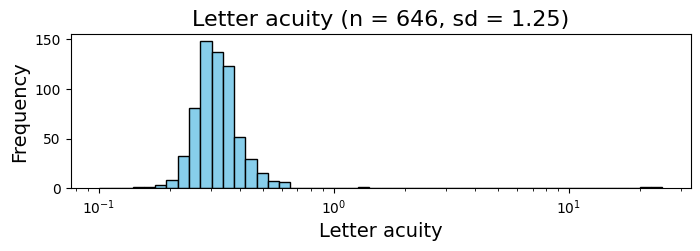

Extracting columns: ['crowding_R8_block1', 'crowding_L8_block1', 'crowding_R8_block2', 'crowding_L8_block2', 'crowding_R8_block3', 'crowding_L8_block3', 'crowding_R8_block4', 'crowding_L8_block4']


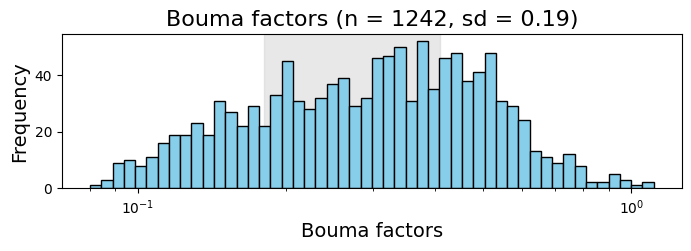

Extracting columns: ['rsvp_foveal_block1', 'rsvp_foveal_block2']


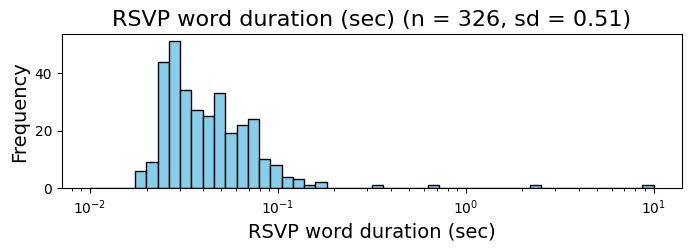

Extracting columns: ['reading_Beaver_block1', 'reading_Winter_block2', 'reading_Desert_block1', 'reading_Islands_block2']


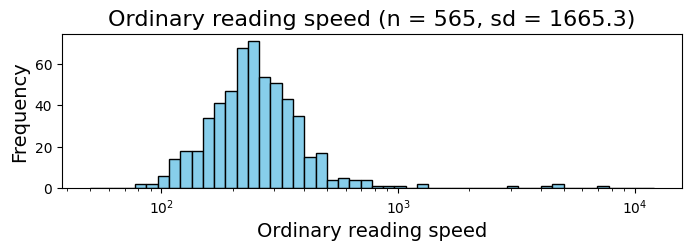

In [68]:
plot_hist_all_tasks(df_both_sessions, extract_category='individual thresh')

Extracting columns: ['acuity_R8_block1', 'acuity_L8_block1', 'acuity_R8_block2', 'acuity_L8_block2']


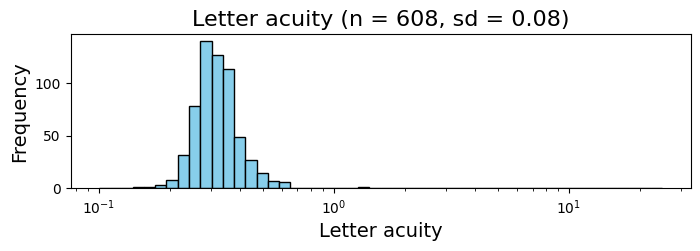

Extracting columns: ['crowding_R8_block1', 'crowding_L8_block1', 'crowding_R8_block2', 'crowding_L8_block2', 'crowding_R8_block3', 'crowding_L8_block3', 'crowding_R8_block4', 'crowding_L8_block4']


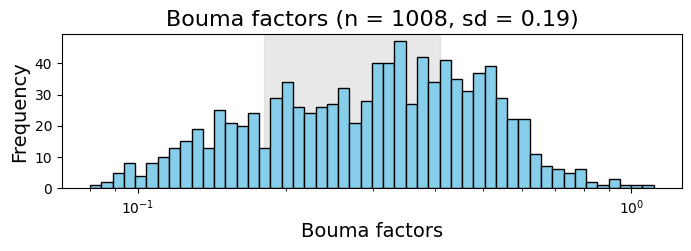

Extracting columns: ['rsvp_foveal_block1', 'rsvp_foveal_block2']


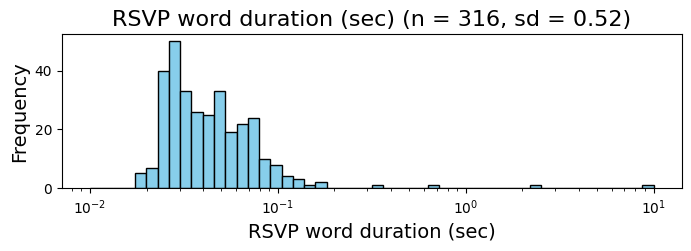

Extracting columns: ['reading_Beaver_block1', 'reading_Winter_block2', 'reading_Desert_block1', 'reading_Islands_block2']


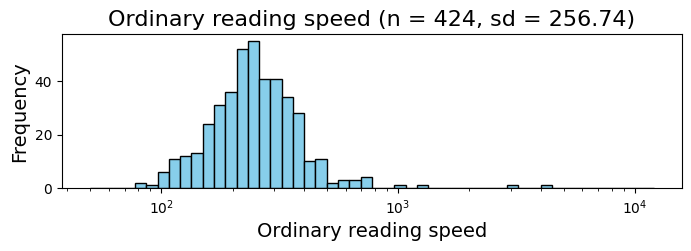

In [69]:
plot_hist_all_tasks(df_both_sessions_exclude_subj_task, extract_category='individual thresh')

### Geometric means for each block:

Extracting columns: ['acuity_gmean_block1', 'acuity_gmean_block2']


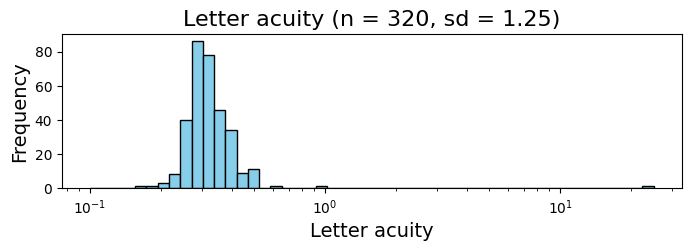

Extracting columns: ['crowding_gmean_block1', 'crowding_gmean_block2', 'crowding_gmean_block3', 'crowding_gmean_block4']


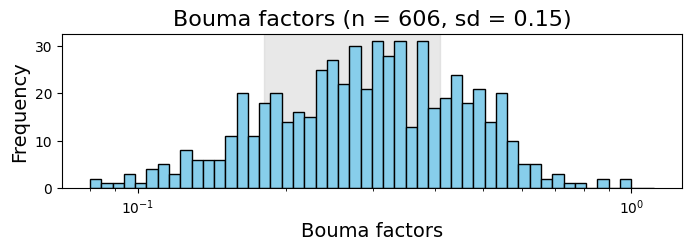

Extracting columns: ['rsvp_foveal_block1', 'rsvp_foveal_block2']


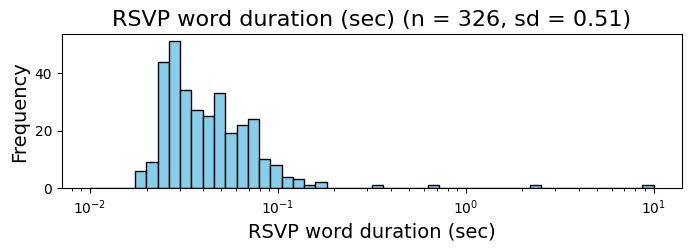

Extracting columns: ['reading_gmean_block1', 'reading_gmean_block2']


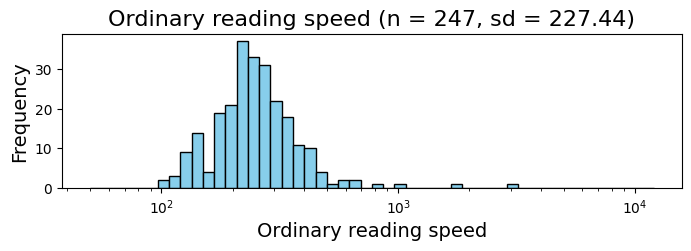

In [70]:
plot_hist_all_tasks(df_summarized_raw, extract_category='block')

Extracting columns: ['acuity_gmean_block1', 'acuity_gmean_block2']


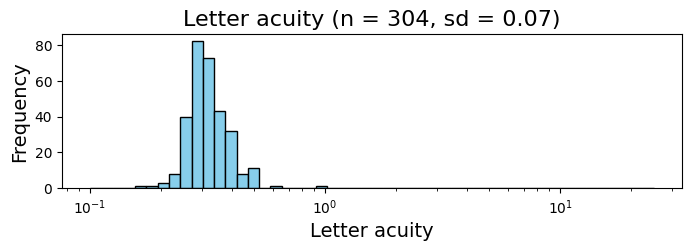

Extracting columns: ['crowding_gmean_block1', 'crowding_gmean_block2', 'crowding_gmean_block3', 'crowding_gmean_block4']


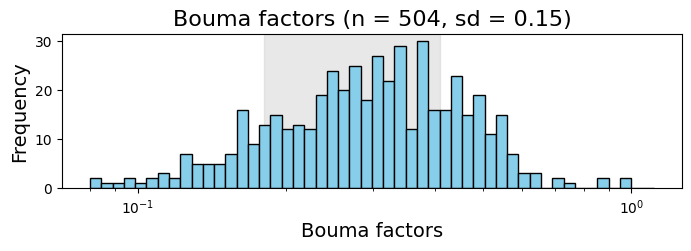

Extracting columns: ['rsvp_foveal_block1', 'rsvp_foveal_block2']


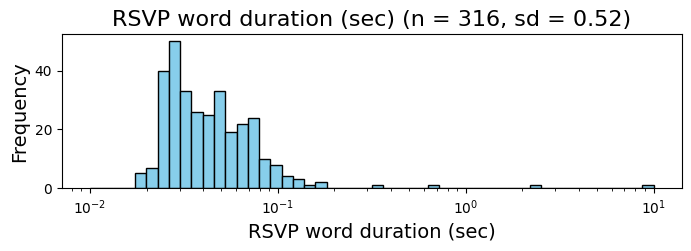

Extracting columns: ['reading_gmean_block1', 'reading_gmean_block2']


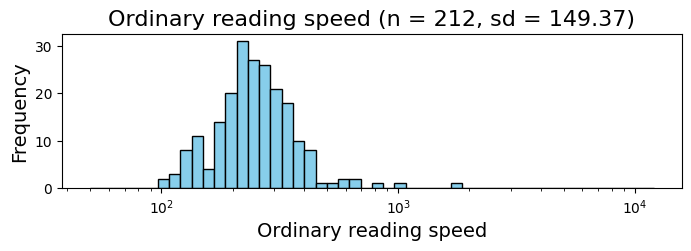

In [71]:
plot_hist_all_tasks(df_summarized, extract_category='block')

### Geometric means for each task

Extracting columns: ['acuity_gmean_task']


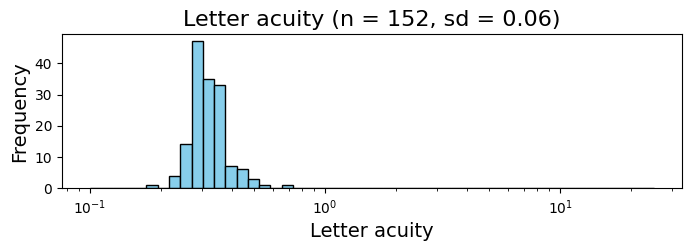

Extracting columns: ['crowding_gmean_task']


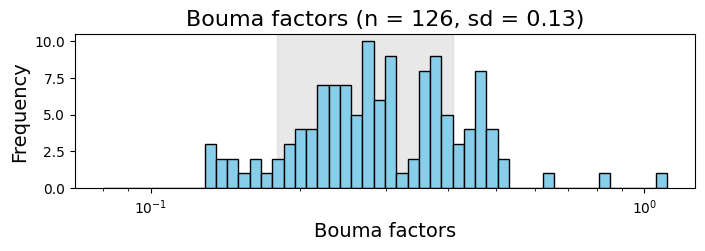

Extracting columns: ['rsvp_gmean_task']


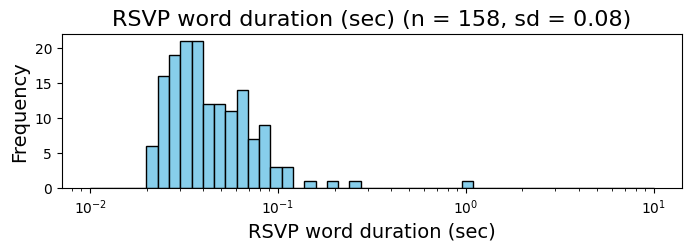

Extracting columns: ['reading_gmean_task']


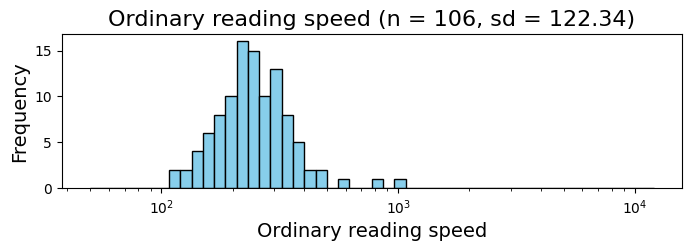

In [72]:
plot_hist_all_tasks(df_summarized_raw, extract_category='task')

Extracting columns: ['acuity_gmean_task']


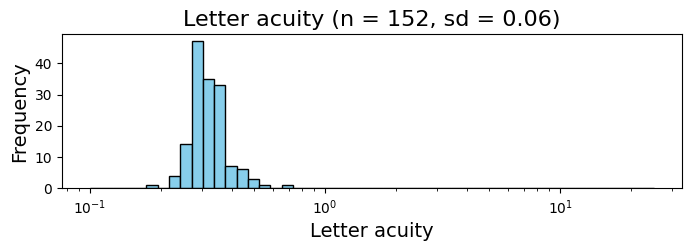

Extracting columns: ['crowding_gmean_task']


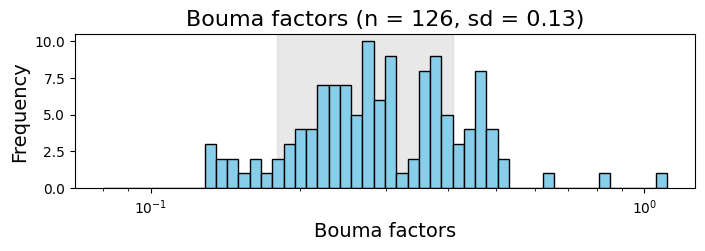

Extracting columns: ['rsvp_gmean_task']


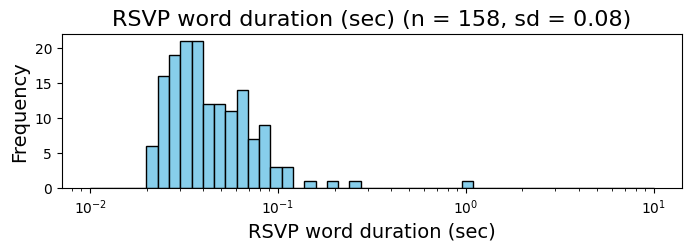

Extracting columns: ['reading_gmean_task']


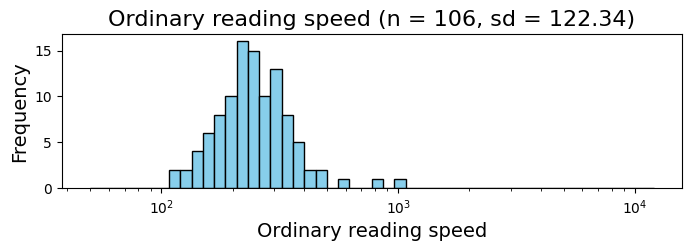

In [73]:
# df_summarized_raw and df_summarized should give the same plots because
# when calculating geometric means, the NaNs are ignored
plot_hist_all_tasks(df_summarized, extract_category='task')

## Clean the data based on test-retest ratio
- log(test/retest), i.e., log(test) - log(retest), note: not the ratio of the logged thresholds; take the ratio between the numerical thresholds and then take the log.
- if test and retest are very different, then it means that the participant is unreliable and therefore should be excluded 

In [31]:
def compute_test_retest_ratio(df, block1_colname, block2_colname):
	'''
	Compute test-retest ratio: log(block2 / block1)
	'''
	ratio = np.log10(df[block2_colname] / df[block1_colname])
	return ratio

# def exclude_ratio(df, ratio_series, threshold=0.3):
# 	'''
# 	Exclude subjects with extreme test-retest ratios.
# 	threshold: if abs(ratio) > threshold, exclude
# 	'''
# 	mask = ratio_series.abs() <= threshold
# 	df_excluded = df[mask].copy()
# 	return df_excluded

In [32]:
df_summarized['acuity_ratio'] = compute_test_retest_ratio(df_summarized, 'acuity_gmean_block1', 'acuity_gmean_block2')
df_summarized['rsvp_ratio'] = compute_test_retest_ratio(df_summarized, 'rsvp_foveal_block1', 'rsvp_foveal_block2')
df_summarized['reading_ratio'] = compute_test_retest_ratio(df_summarized, 'reading_gmean_block1', 'reading_gmean_block2')

df_summarized['crowding_ratio_12'] = compute_test_retest_ratio(df_summarized, 'crowding_gmean_block1', 'crowding_gmean_block2')
df_summarized['crowding_ratio_13'] = compute_test_retest_ratio(df_summarized, 'crowding_gmean_block1', 'crowding_gmean_block3')
df_summarized['crowding_ratio_14'] = compute_test_retest_ratio(df_summarized, 'crowding_gmean_block1', 'crowding_gmean_block4')		
df_summarized['crowding_ratio_23'] = compute_test_retest_ratio(df_summarized, 'crowding_gmean_block2', 'crowding_gmean_block3')
df_summarized['crowding_ratio_24'] = compute_test_retest_ratio(df_summarized, 'crowding_gmean_block2', 'crowding_gmean_block4')
df_summarized['crowding_ratio_34'] = compute_test_retest_ratio(df_summarized, 'crowding_gmean_block3', 'crowding_gmean_block4')


In [33]:
def plot_ratio(data_array, title, num_bins=80, min_val=-2.5, max_val=2.5, abs_bool=False): # , num_bins=20, min_val=0.08, max_val=1.11
    '''
    Input:
    - data_array: an array of test-retest ratios
    - title: [string] title and x-axis label of the figure
    '''
    
    # make the bins look the same size on a log scale
    # min_val = round(np.nanmin(data_array),2)
    # max_val = round(np.nanmax(data_array),2)
    # print(f'Min and max bin limits: {min_val}, {max_val}')
    bins = np.linspace(min_val, max_val, num_bins + 1)
    if abs_bool:
        data_array = np.abs(data_array)
        title = 'Absolute ' + title
                
    plt.figure(figsize=(8, 2)) 
    plt.hist(data_array, bins=bins, color='lightyellow', edgecolor='black')# bins=bins
    plt.title(f"{title} (n = {np.count_nonzero(~np.isnan(data_array))})", fontsize = 16)
    plt.xlabel(title, fontsize = 14)
    plt.ylabel("Frequency", fontsize = 14)
    plt.xlim(min_val, max_val)
    # plt.ylim(0,100)
    # add ticks and format them as normal floats
    # tick_positions = np.linspace(0.1, 1, num=10)  
    # plt.xticks(tick_positions, labels=[f"{x:.1f}" for x in tick_positions])

    
    plt.show()

Sanity check: the distributions of the values of the ratios are normal centered at 0

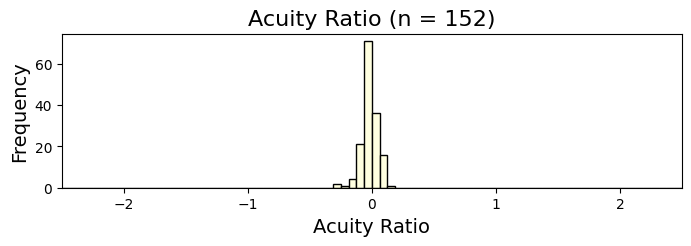

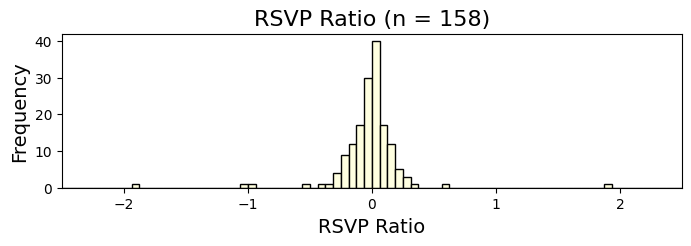

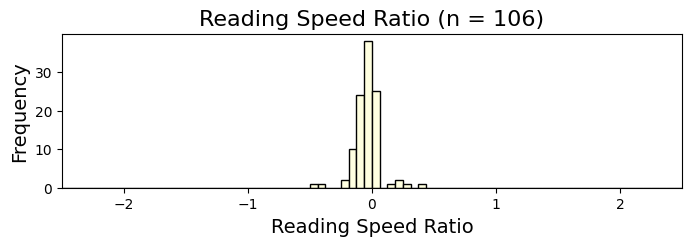

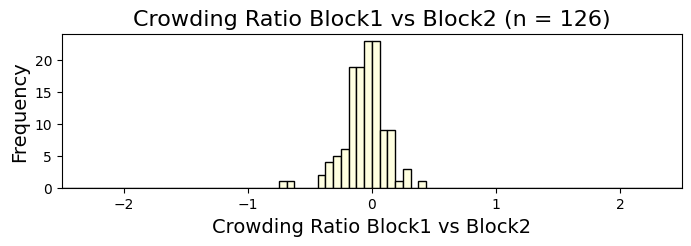

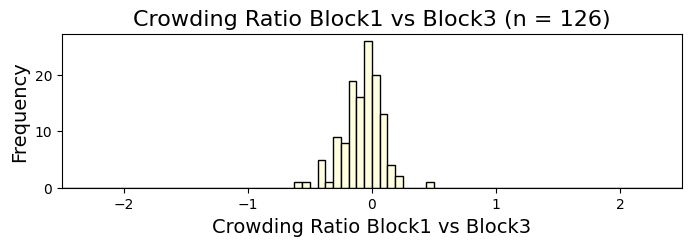

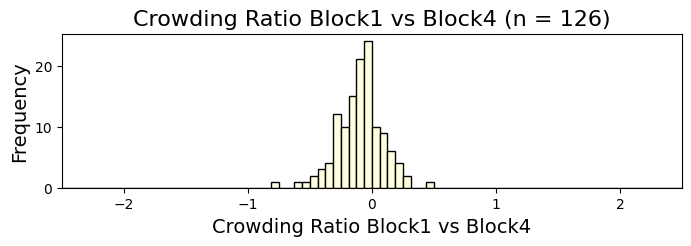

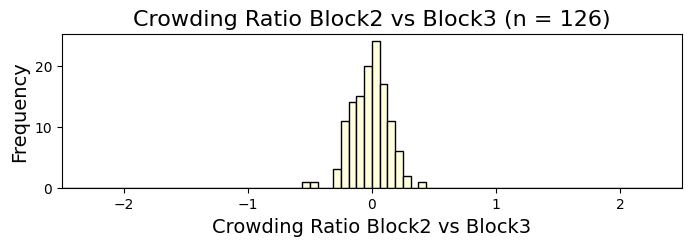

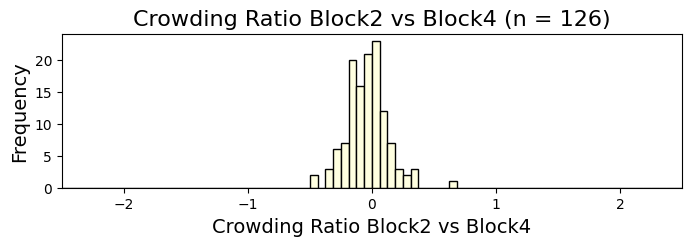

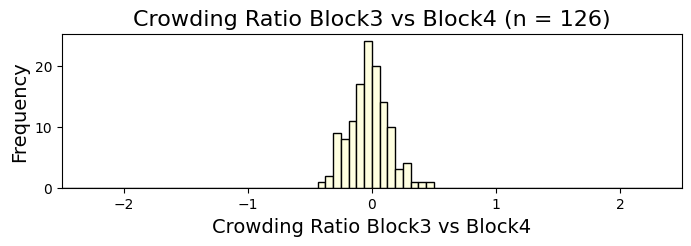

In [34]:
plot_ratio(df_summarized['acuity_ratio'], 'Acuity Ratio')
plot_ratio(df_summarized['rsvp_ratio'], 'RSVP Ratio')
plot_ratio(df_summarized['reading_ratio'], 'Reading Speed Ratio')
plot_ratio(df_summarized['crowding_ratio_12'], 'Crowding Ratio Block1 vs Block2')
plot_ratio(df_summarized['crowding_ratio_13'], 'Crowding Ratio Block1 vs Block3')
plot_ratio(df_summarized['crowding_ratio_14'], 'Crowding Ratio Block1 vs Block4')
plot_ratio(df_summarized['crowding_ratio_23'], 'Crowding Ratio Block2 vs Block3')
plot_ratio(df_summarized['crowding_ratio_24'], 'Crowding Ratio Block2 vs Block4')
plot_ratio(df_summarized['crowding_ratio_34'], 'Crowding Ratio Block3 vs Block4')

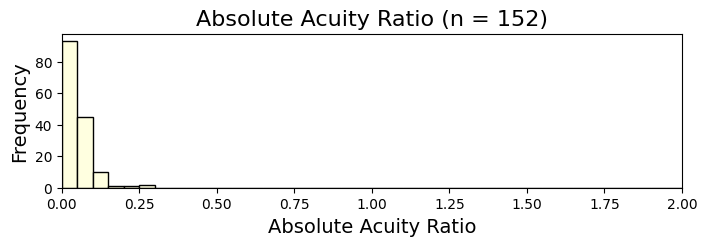

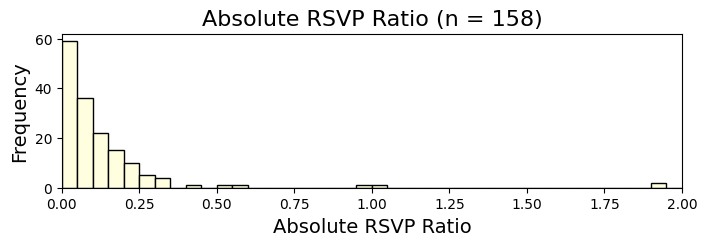

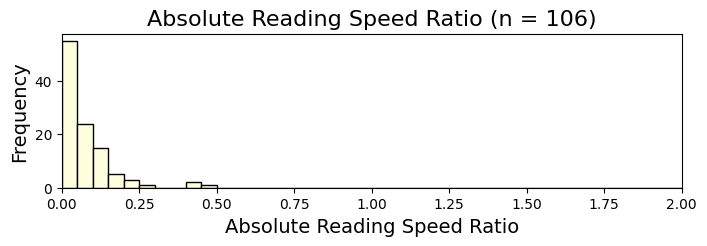

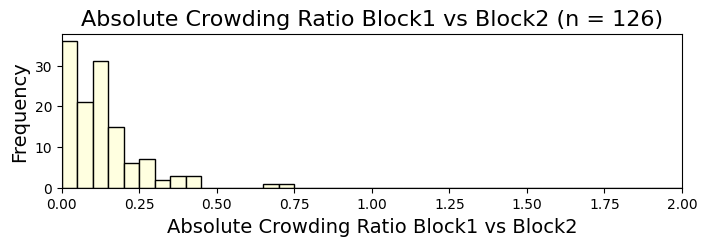

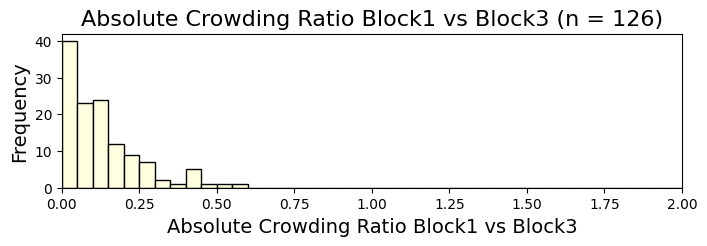

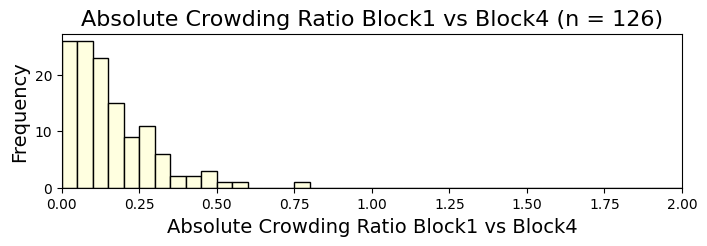

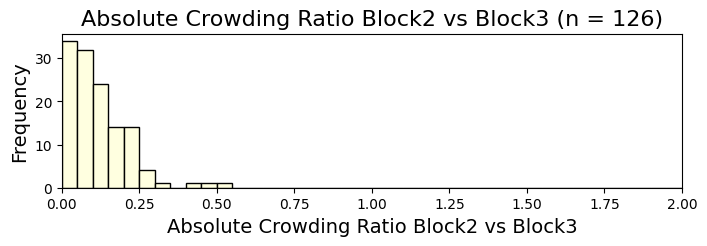

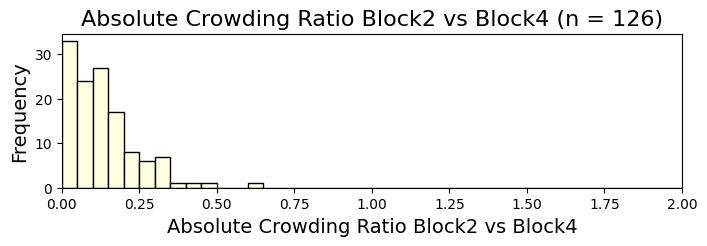

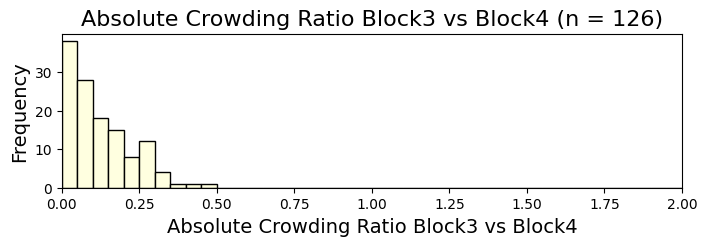

In [35]:
plot_ratio(df_summarized['acuity_ratio'], 'Acuity Ratio', abs_bool=True, num_bins=40, min_val=0, max_val=2)
plot_ratio(df_summarized['rsvp_ratio'], 'RSVP Ratio', abs_bool=True, num_bins=40, min_val=0, max_val=2)
plot_ratio(df_summarized['reading_ratio'], 'Reading Speed Ratio', abs_bool=True, num_bins=40, min_val=0, max_val=2)
plot_ratio(df_summarized['crowding_ratio_12'], 'Crowding Ratio Block1 vs Block2', abs_bool=True, num_bins=40, min_val=0, max_val=2)
plot_ratio(df_summarized['crowding_ratio_13'], 'Crowding Ratio Block1 vs Block3', abs_bool=True, num_bins=40, min_val=0, max_val=2)
plot_ratio(df_summarized['crowding_ratio_14'], 'Crowding Ratio Block1 vs Block4', abs_bool=True, num_bins=40, min_val=0, max_val=2)
plot_ratio(df_summarized['crowding_ratio_23'], 'Crowding Ratio Block2 vs Block3', abs_bool=True, num_bins=40, min_val=0, max_val=2)
plot_ratio(df_summarized['crowding_ratio_24'], 'Crowding Ratio Block2 vs Block4', abs_bool=True, num_bins=40, min_val=0, max_val=2)
plot_ratio(df_summarized['crowding_ratio_34'], 'Crowding Ratio Block3 vs Block4', abs_bool=True, num_bins=40, min_val=0, max_val=2)

In [36]:
def remove_outliers_ratio(df, prefix):
	'''
	Remove subjects with extreme test-retest ratios.
	'''
	df = df.copy()
	ratio_cols = [col for col in df.columns if col.startswith(prefix) and 'ratio' in col]

	for col in ratio_cols:

		ratio_values = df[col]
		mean = ratio_values.mean(skipna=True)
		std = ratio_values.std(skipna=True)
		lower = mean - 2 * std
		upper = mean + 2 * std

		outlier_mask = (ratio_values < lower) | (ratio_values > upper)
		num_outliers = outlier_mask.sum()

		# Find the corresponding threshold column (e.g., 'crowding_block1')
		task_cols = [col for col in df.columns if col.startswith(prefix) and not 'ratio' in col]

		for task_col in task_cols:

			if task_col in df.columns:
				df.loc[outlier_mask, task_col] = np.nan
				print(f'Set {num_outliers} values in {task_col} to NaN due to outlier {col} (thresholds: {lower:.2f} to {upper:.2f})')
			else:
				print(f'Warning: {task_col} not found in DataFrame.')

		df.loc[outlier_mask, col] = np.nan


	return df

In [37]:
df_cleaned = df_summarized.copy()
df_cleaned = remove_outliers_ratio(df_cleaned, 'acuity')
df_cleaned = remove_outliers_ratio(df_cleaned, 'rsvp')
df_cleaned = remove_outliers_ratio(df_cleaned, 'reading')
df_cleaned = remove_outliers_ratio(df_cleaned, 'crowding')

Set 8 values in acuity_R8_block1 to NaN due to outlier acuity_ratio (thresholds: -0.15 to 0.11)
Set 8 values in acuity_L8_block1 to NaN due to outlier acuity_ratio (thresholds: -0.15 to 0.11)
Set 8 values in acuity_R8_block2 to NaN due to outlier acuity_ratio (thresholds: -0.15 to 0.11)
Set 8 values in acuity_L8_block2 to NaN due to outlier acuity_ratio (thresholds: -0.15 to 0.11)
Set 8 values in acuity_gmean_block1 to NaN due to outlier acuity_ratio (thresholds: -0.15 to 0.11)
Set 8 values in acuity_gmean_block2 to NaN due to outlier acuity_ratio (thresholds: -0.15 to 0.11)
Set 8 values in acuity_gmean_task to NaN due to outlier acuity_ratio (thresholds: -0.15 to 0.11)
Set 5 values in rsvp_foveal_block1 to NaN due to outlier rsvp_ratio (thresholds: -0.58 to 0.54)
Set 5 values in rsvp_foveal_block2 to NaN due to outlier rsvp_ratio (thresholds: -0.58 to 0.54)
Set 5 values in rsvp_gmean_task to NaN due to outlier rsvp_ratio (thresholds: -0.58 to 0.54)
Set 6 values in reading_Beaver_block

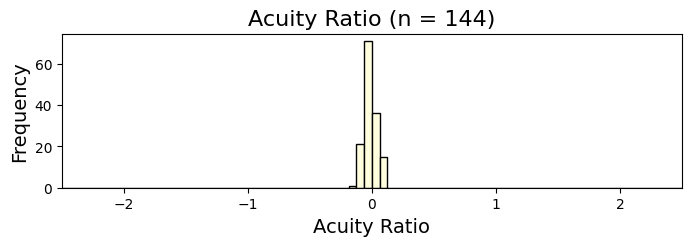

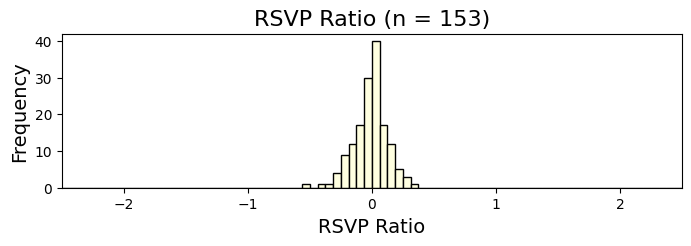

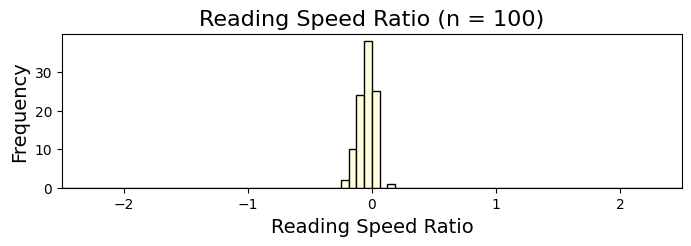

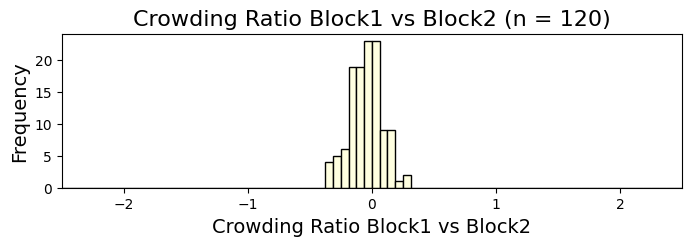

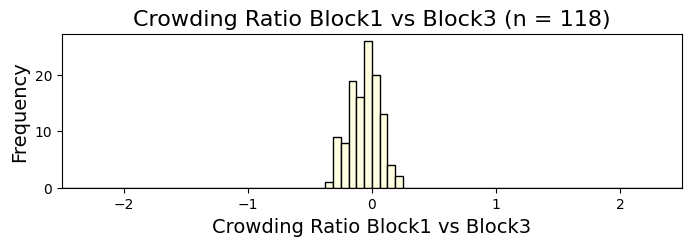

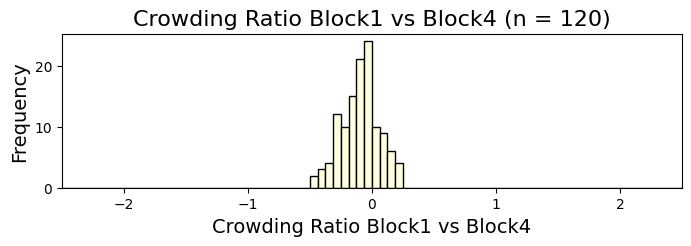

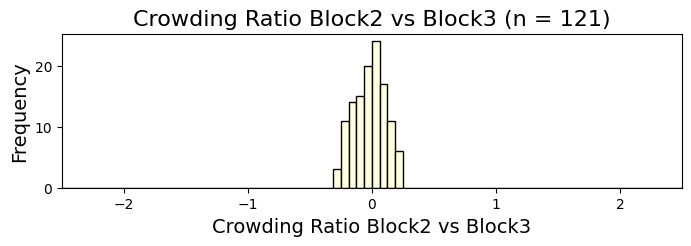

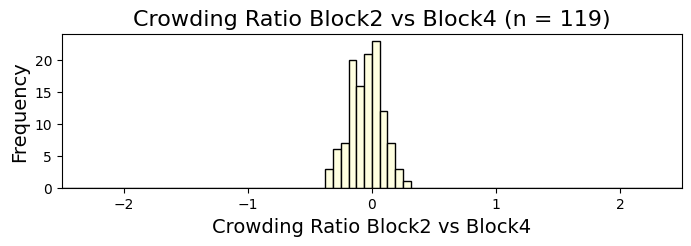

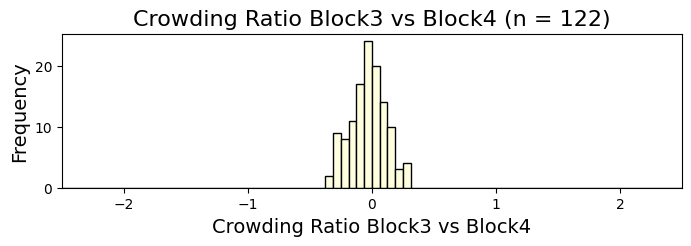

In [38]:
# plot ratios after removing outliers
plot_ratio(df_cleaned['acuity_ratio'], 'Acuity Ratio')
plot_ratio(df_cleaned['rsvp_ratio'], 'RSVP Ratio')
plot_ratio(df_cleaned['reading_ratio'], 'Reading Speed Ratio')
plot_ratio(df_cleaned['crowding_ratio_12'], 'Crowding Ratio Block1 vs Block2')
plot_ratio(df_cleaned['crowding_ratio_13'], 'Crowding Ratio Block1 vs Block3')
plot_ratio(df_cleaned['crowding_ratio_14'], 'Crowding Ratio Block1 vs Block4')
plot_ratio(df_cleaned['crowding_ratio_23'], 'Crowding Ratio Block2 vs Block3')
plot_ratio(df_cleaned['crowding_ratio_24'], 'Crowding Ratio Block2 vs Block4')
plot_ratio(df_cleaned['crowding_ratio_34'], 'Crowding Ratio Block3 vs Block4')

## Histograms of all thresholds -- Cleaned data

Extracting columns: ['acuity_R8_block1', 'acuity_L8_block1', 'acuity_R8_block2', 'acuity_L8_block2']


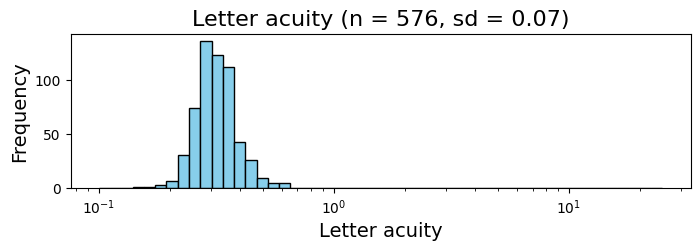

Extracting columns: ['crowding_R8_block1', 'crowding_L8_block1', 'crowding_R8_block2', 'crowding_L8_block2', 'crowding_R8_block3', 'crowding_L8_block3', 'crowding_R8_block4', 'crowding_L8_block4']


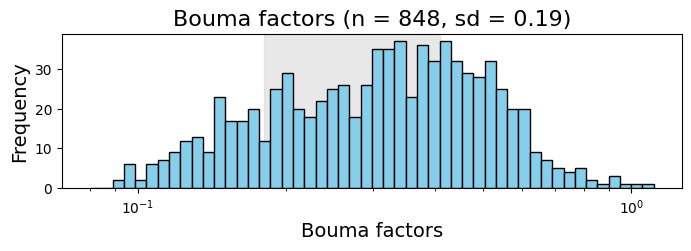

Extracting columns: ['rsvp_foveal_block1', 'rsvp_foveal_block2']


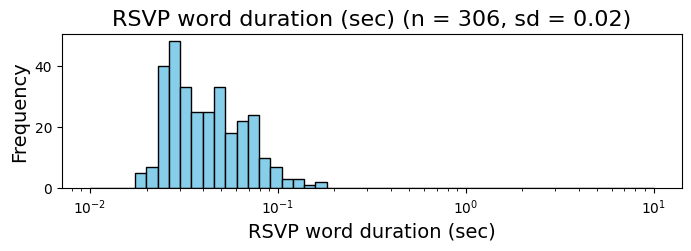

Extracting columns: ['reading_Beaver_block1', 'reading_Winter_block2', 'reading_Desert_block1', 'reading_Islands_block2']


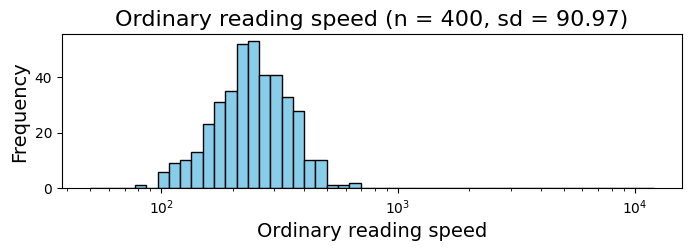

In [74]:
plot_hist_all_tasks(df_cleaned, extract_category='individual thresh')

Extracting columns: ['acuity_gmean_block1', 'acuity_gmean_block2']


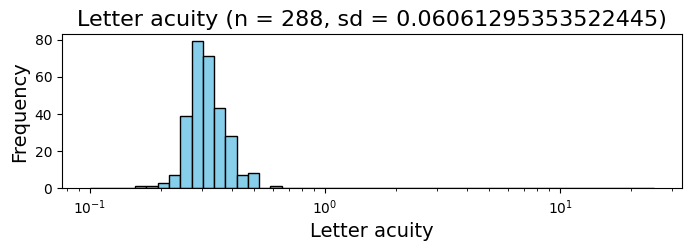

Extracting columns: ['crowding_gmean_block1', 'crowding_gmean_block2', 'crowding_gmean_block3', 'crowding_gmean_block4']


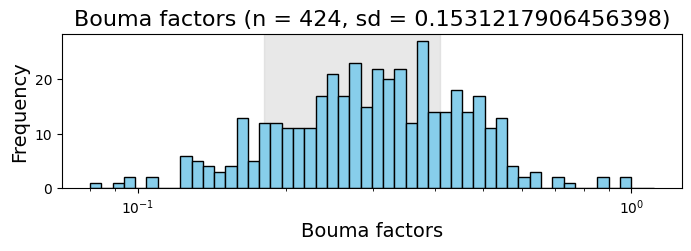

Extracting columns: ['rsvp_foveal_block1', 'rsvp_foveal_block2']


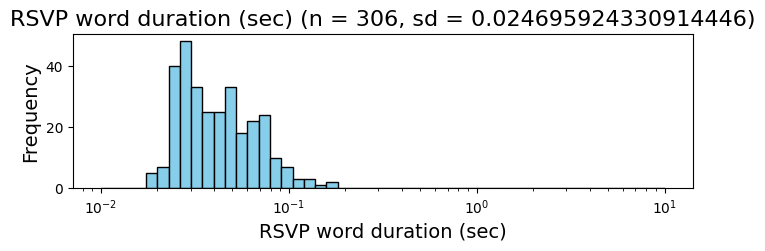

Extracting columns: ['reading_gmean_block1', 'reading_gmean_block2']


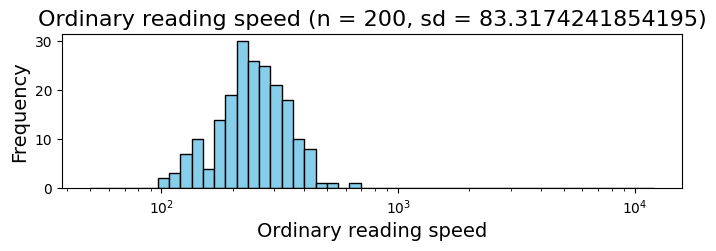

In [40]:
plot_hist_all_tasks(df_cleaned, extract_category='block')

Extracting columns: ['acuity_gmean_task']


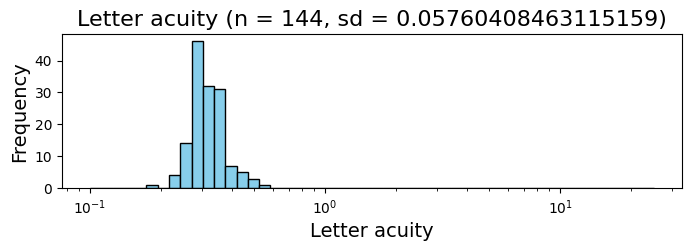

Extracting columns: ['crowding_gmean_task']


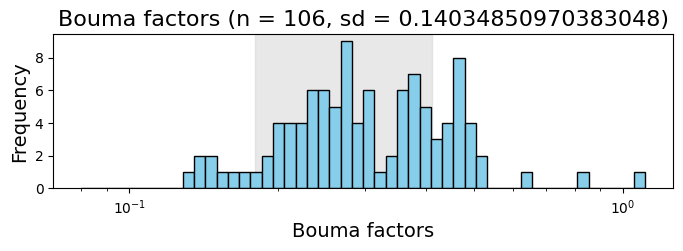

Extracting columns: ['rsvp_gmean_task']


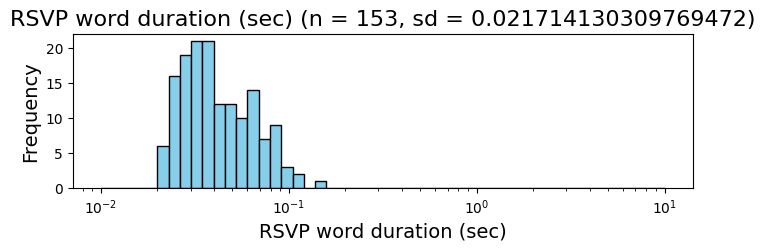

Extracting columns: ['reading_gmean_task']


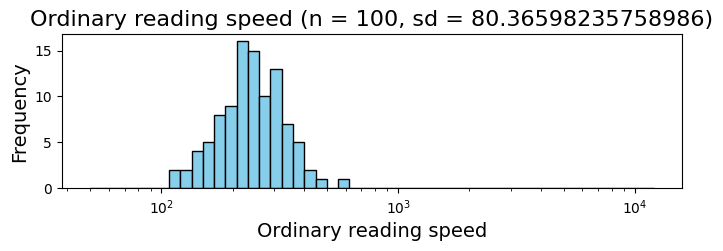

In [41]:
plot_hist_all_tasks(df_cleaned, extract_category='task')

# Analysis
- note that everything in df_cleaned is not logged

In [42]:
df_for_analysis = df_cleaned.copy()

## Function

In [43]:
def plot_scatter_with_correlation(df, var_x, var_y, title, log_data_bool=True,
                                  plotXequalsY_bool=False, equal_axes_bool=True):
    """
    Plots a scatter plot of two variables from a DataFrame and computes Pearson's r.
    
    Parameters:
        df (pd.DataFrame): The data frame containing the variables.
        var_x (str): Name of the first variable (x-axis).
        var_y (str): Name of the second variable (y-axis).
    """
    df = df.copy()

    if log_data_bool:
        # Log-transform the data, avoiding log(0) or log(negative)
        df[var_x] = np.log10(df[var_x].replace(0, np.nan))
        df[var_y] = np.log10(df[var_y].replace(0, np.nan))
    
	# print out minimum and maximum values of the variables
    min_x = df[var_x].min()
    min_y = df[var_y].min()
    max_x = df[var_x].max()
    max_y = df[var_y].max()
    print(f'Min and max values: min_x: {min_x}, max_x: {max_x}, min_y: {min_y}, max_y: {max_y}')
    
    # Compute Pearson correlation
    valid = (~np.isnan(df[var_x])) & (~np.isnan(df[var_y]))
    r, p_value = stats.pearsonr(df[var_x][valid], df[var_y][valid])

    # Determine axis limits (same for both axes)
    min_val = min(df[var_x].min(), df[var_y].min())
    min_val = min_val - abs(min_val) * 0.2
    max_val = max(df[var_x].max(), df[var_y].max())
    max_val = max_val + abs(max_val) * 0.2


    # Create the scatter plot
    plt.figure(figsize=(4, 4))  
    sns.scatterplot(x=df[var_x], y=df[var_y], s=50)

    # plot x = y
    if plotXequalsY_bool:
            plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", linewidth=1.5)
            
    # Set limits for both axes to be the same
    if equal_axes_bool:
        plt.axis('equal')
        plt.gca().set_aspect('equal', adjustable='box')
        # plt.xlim(min_val, max_val)
        # plt.ylim(min_val, max_val)
    else:
        plt.gca().set_aspect('auto', adjustable='box')  


    # Add title with Pearson's r value
    plt.title(title + f"\n r = {r:.2f}", fontsize=16)
    
    # Add labels
    plt.xlabel(var_x, fontsize=14)
    plt.ylabel(var_y, fontsize=14)
    plt.xticks(fontsize=10)  
    plt.yticks(fontsize=10) 
    
        
    # Show plot
    plt.show()


## Test-retest

Min and max values: min_x: -0.28486264400000005, max_x: 0.8456866949999999, min_y: -0.28864219649999995, max_y: 0.901201004


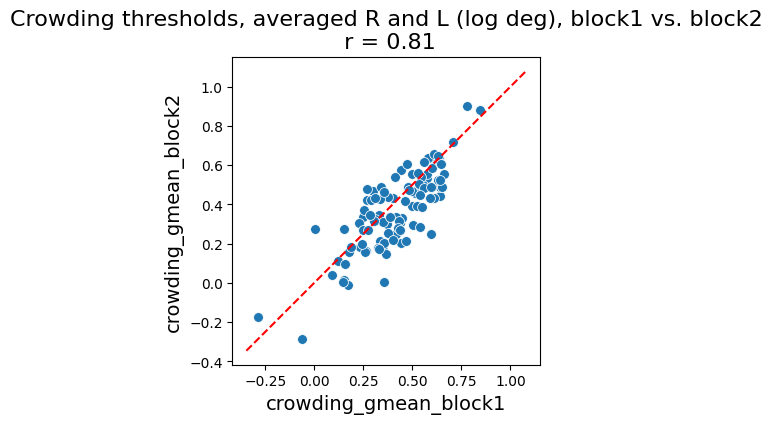

In [44]:
plot_scatter_with_correlation(df_for_analysis, "crowding_gmean_block1", "crowding_gmean_block2", 
                              'Crowding thresholds, averaged R and L (log deg), block1 vs. block2', plotXequalsY_bool=True)

Min and max values: min_x: -0.4322539585, max_x: 0.950354103, min_y: -0.40871242249999995, max_y: 1.04075982


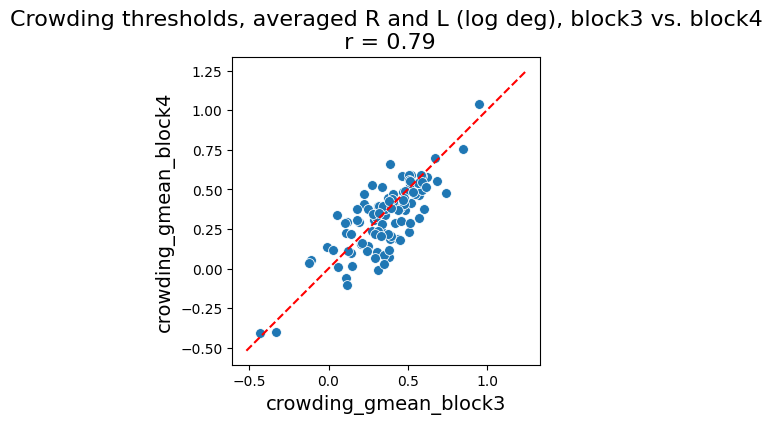

In [45]:
plot_scatter_with_correlation(df_for_analysis, "crowding_gmean_block3", "crowding_gmean_block4", 
                              'Crowding thresholds, averaged R and L (log deg), block3 vs. block4', plotXequalsY_bool=True)


Min and max values: min_x: -0.28486264400000005, max_x: 0.8456866949999999, min_y: -0.40871242249999995, max_y: 1.04075982


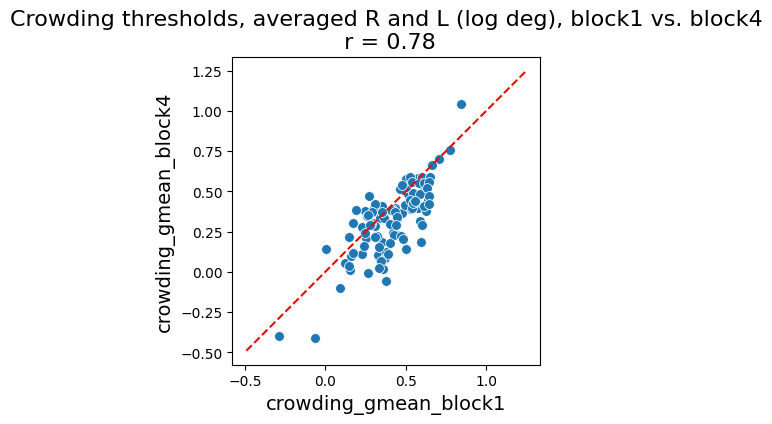

In [46]:
plot_scatter_with_correlation(df_for_analysis, "crowding_gmean_block1", "crowding_gmean_block4", 
                              'Crowding thresholds, averaged R and L (log deg), block1 vs. block4', plotXequalsY_bool=True)

Min and max values: min_x: -0.7324677135000001, max_x: -0.216273549, min_y: -0.778732197, max_y: -0.2847650095


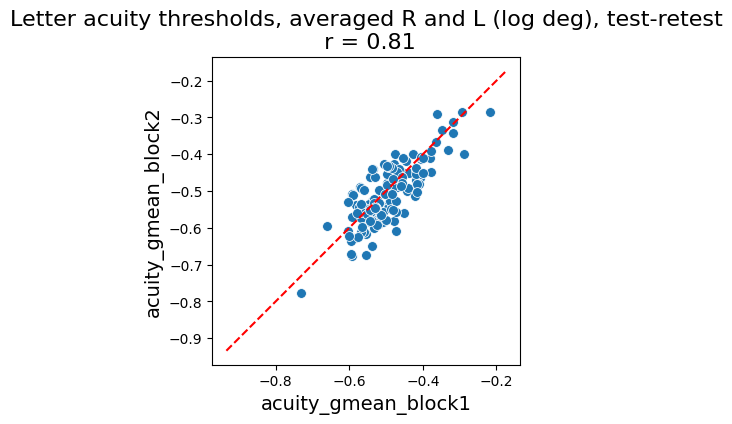

In [47]:
plot_scatter_with_correlation(df_for_analysis, "acuity_gmean_block1", "acuity_gmean_block2", 
                              'Letter acuity thresholds, averaged R and L (log deg), test-retest', plotXequalsY_bool=True)


Min and max values: min_x: 0.01970168789968353, max_x: 0.17970987247286835, min_y: 0.01970168789968353, max_y: 0.1273610550284859


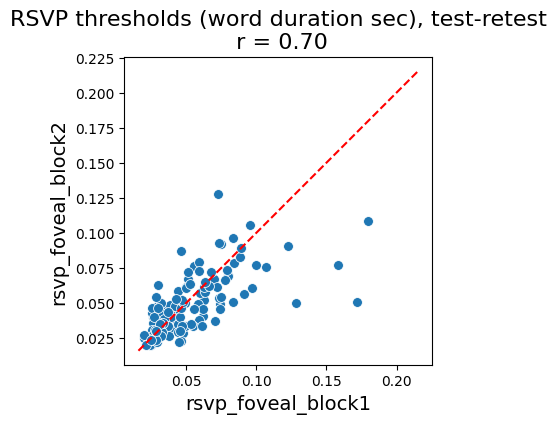

In [48]:
plot_scatter_with_correlation(df_for_analysis, "rsvp_foveal_block1", "rsvp_foveal_block2",
                                'RSVP thresholds (word duration sec), test-retest', log_data_bool=False, plotXequalsY_bool=True)


Min and max values: min_x: 2.0211946698989363, max_x: 2.8095027999307023, min_y: 2.0247515956919573, max_y: 2.7132561892007505


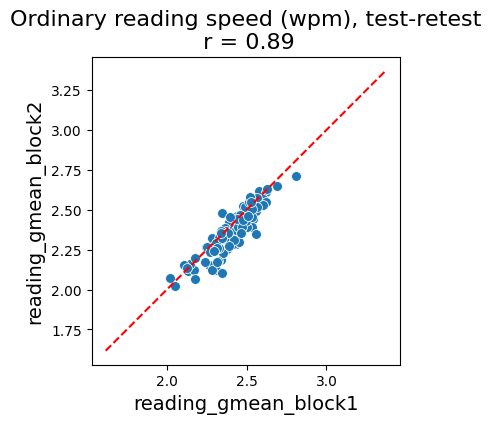

In [49]:
plot_scatter_with_correlation(df_for_analysis, "reading_gmean_block1", "reading_gmean_block2",
                                'Ordinary reading speed (wpm), test-retest', plotXequalsY_bool=True)

## Is there left-right asymmetry?

In [50]:
# plot_scatter_with_correlation(df_subj_avg, "crowding_R8", "crowding_L8", 
#                               'Crowding, right vs. left', plotXequalsY_bool=True)

In [51]:
# plot_scatter_with_correlation(df_subj_avg, "acuity_R8", "acuity_L8", 
#                               'Letter acuity, right vs. left', plotXequalsY_bool=True)

## Correlation between tasks

### Scatter plots with measured R

Min and max values: min_x: -1.6891992449999997, max_x: -0.8550828359999999, min_y: -0.29858858325, max_y: 0.929864890375


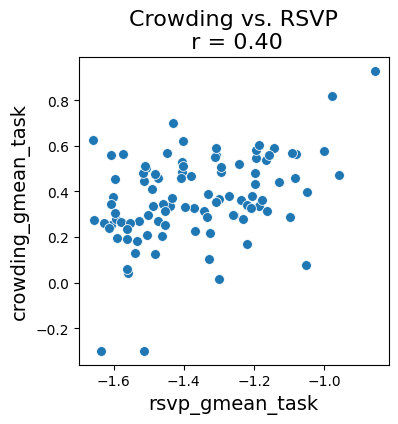

In [52]:
plot_scatter_with_correlation(df_for_analysis, "rsvp_gmean_task", "crowding_gmean_task", 
                              'Crowding vs. RSVP', equal_axes_bool=False)

Min and max values: min_x: 2.0391113692830287, max_x: 2.761379494565726, min_y: -0.29858858325, max_y: 0.929864890375


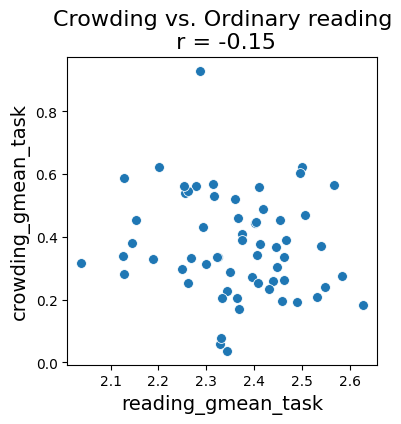

In [53]:
plot_scatter_with_correlation(df_for_analysis, "reading_gmean_task", "crowding_gmean_task", 
                              'Crowding vs. Ordinary reading', equal_axes_bool=False)

Min and max values: min_x: -0.75559995525, max_x: -0.25051927925, min_y: -0.29858858325, max_y: 0.929864890375


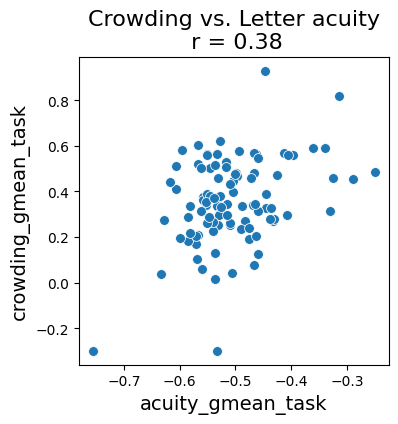

In [54]:
plot_scatter_with_correlation(df_for_analysis, "acuity_gmean_task", "crowding_gmean_task", 
                              'Crowding vs. Letter acuity', equal_axes_bool=False)

Min and max values: min_x: -0.75559995525, max_x: -0.25051927925, min_y: -1.6891992449999997, max_y: -0.8550828359999999


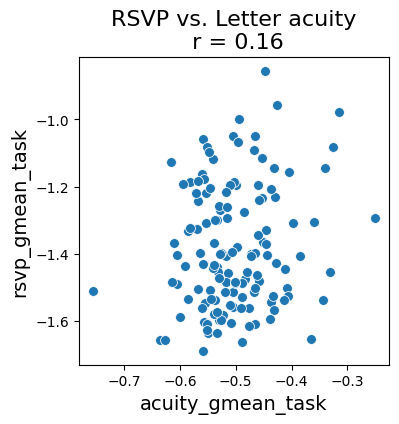

In [55]:
plot_scatter_with_correlation(df_for_analysis, "acuity_gmean_task", "rsvp_gmean_task", 
                              'RSVP vs. Letter acuity', equal_axes_bool=False)

Min and max values: min_x: -0.75559995525, max_x: -0.25051927925, min_y: 2.0391113692830287, max_y: 2.761379494565726


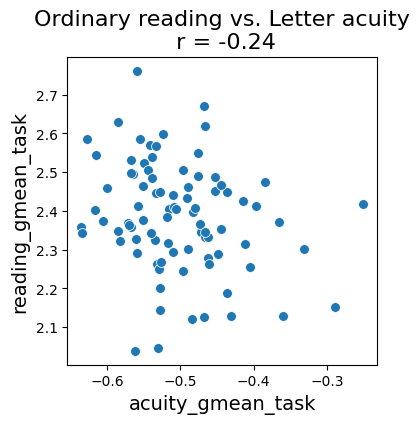

In [56]:
plot_scatter_with_correlation(df_for_analysis, "acuity_gmean_task", "reading_gmean_task", 
                              'Ordinary reading vs. Letter acuity', equal_axes_bool=False)

### Data frame with measured and corrected R (outdated)

In [57]:
def calc_within_subj_variance(df, task_prefix):
    """Calculate within-subject variance for all subjects for a given task prefix."""
    task_cols = [col for col in df.columns if col.startswith(task_prefix)]
    # Calculate variance for each subject (row) across repeats (columns)
    return df[task_cols].var(axis=1, ddof=1).mean()

def calc_between_subj_variance(df, task_prefix):
    """Calculate between-subject variance for a given task prefix."""
    task_cols = [col for col in df.columns if col.startswith(task_prefix)]
    # Average across repeats for each subject
    subj_means = df[task_cols].mean(axis=1)
    # Variance between subjects
    return np.nanvar(subj_means, ddof=1)

def calc_mean(df, task_prefix):
    """Calculate mean for all thresholds for a given task prefix."""
    task_cols = [col for col in df.columns if col.startswith(task_prefix)]
    # first average across repeats for each subject
    subj_means = df[task_cols].mean(axis=1)
    # then average across subjects
    return np.nanmean(subj_means)

def compute_noise_ceiling(df, task_prefix):
	"""
	Reference: Diedrichsen
	Computes the noise ceiling for a set of repeated measurements.
	Uses split-half reliability across multiple measurements and the geometric mean formula.
	"""
	task_cols = [col for col in df.columns if col.startswith(task_prefix)]
	measurements = df[task_cols]

	n_measurements = measurements.shape[1]
	
	first_half = measurements.iloc[:, :n_measurements//2]
	last_half = measurements.iloc[:, n_measurements//2:]
	odd_half = measurements.iloc[:, 1::2]
	even_half = measurements.iloc[:, 0::2]
	
	# Compute means while ignoring NaN
	mean_first_half = np.mean(first_half, axis=1)
	mean_last_half = np.mean(last_half, axis=1)

	# Filter out rows where either mean is NaN
	valid_indices = ~np.isnan(mean_first_half) & ~np.isnan(mean_last_half)

	# Compute Pearson correlation only for valid rows
	r_firstLast, _ = stats.pearsonr(mean_first_half[valid_indices], mean_last_half[valid_indices])

	# Repeat for odd/even halves
	mean_odd_half = np.mean(odd_half, axis=1)
	mean_even_half = np.mean(even_half, axis=1)

     
	valid_indices = ~np.isnan(mean_odd_half) & ~np.isnan(mean_even_half)
	r_oddEven, _ = stats.pearsonr(mean_odd_half[valid_indices], mean_even_half[valid_indices])
	
	# Compute the split-half reliability as the geometric mean
	r_i = np.sqrt(r_firstLast * r_oddEven)

	# Apply the extrapolation formula for multiple measurements
	N = 2
	r_m = (N * r_i) / ((r_i * (N - 1)) + 1)

	return r_m


def gather_results(df, task_prefixes):
    """Gather results for within and between subject variance."""
    results = []
    for task in task_prefixes:

		
        within_var = calc_within_subj_variance(df, task)
        between_var = calc_between_subj_variance(df, task)
        mean_val = calc_mean(df, task)
        r_ceiling = compute_noise_ceiling(df, task)
        
        results.append({'task': task, 'within_subj_variance': within_var, 
                        'btw_subj_variance': between_var, 'mean': mean_val,
                        'r_ceiling': r_ceiling})
    return pd.DataFrame(results)

In [58]:
def print_measured_corrected_r(df, var_x, var_y, noise_ceiling_x, noise_ceiling_y):
    """
    Plots a scatter plot of two variables from a DataFrame and computes Pearson's r.
    
    Parameters:
        df (pd.DataFrame): The data frame containing the variables.
        var_x (str): Name of the first variable (x-axis).
        var_y (str): Name of the second variable (y-axis).
    """
    df = df.copy()
    
    
    # Compute Pearson correlation
    valid = (~np.isnan(df[var_x])) & (~np.isnan(df[var_y]))
    r_measured, p_value = stats.pearsonr(df[var_x][valid], df[var_y][valid])

    # correction
    noise_ceiling = np.sqrt(noise_ceiling_x * noise_ceiling_y)
    r_corrected = r_measured / noise_ceiling

    print(f"Correlating: {var_x} and {var_y}: Pearson's r (measured): {r_measured:.2f}, r (corrected): {r_corrected:.2f}")
    print(f"Noise ceilings: {var_x}: {noise_ceiling_x:.2f}; {var_y}: {noise_ceiling_y:.2f}; combined: {noise_ceiling:.2f}")

    df_corr_results = pd.DataFrame({
        'var_x': [var_x],
        'var_y': [var_y],
        'noise_ceiling_x': [noise_ceiling_x],
        'noise_ceiling_y': [noise_ceiling_y],
        'r_measured': [r_measured],
        'r_corrected': [r_corrected]
    })

    return df_corr_results

    



In [59]:
print(df_for_analysis.columns)

Index(['prolificID', 'crowding_R8_block1', 'crowding_L8_block1',
       'crowding_R8_block2', 'crowding_L8_block2', 'acuity_R8_block1',
       'acuity_L8_block1', 'rsvp_foveal_block1', 'reading_Beaver_block1',
       'reading_Winter_block2', 'crowding_R8_block3', 'crowding_L8_block3',
       'crowding_R8_block4', 'crowding_L8_block4', 'acuity_R8_block2',
       'acuity_L8_block2', 'rsvp_foveal_block2', 'reading_Desert_block1',
       'reading_Islands_block2', 'crowding_gmean_block1',
       'crowding_gmean_block2', 'crowding_gmean_block3',
       'crowding_gmean_block4', 'acuity_gmean_block1', 'acuity_gmean_block2',
       'reading_gmean_block1', 'reading_gmean_block2', 'acuity_gmean_task',
       'crowding_gmean_task', 'rsvp_gmean_task', 'reading_gmean_task',
       'acuity_ratio', 'rsvp_ratio', 'reading_ratio', 'crowding_ratio_12',
       'crowding_ratio_13', 'crowding_ratio_14', 'crowding_ratio_23',
       'crowding_ratio_24', 'crowding_ratio_34'],
      dtype='object')


In [60]:
col_for_variance = ['crowding_gmean_block1', 'crowding_gmean_block2', 'crowding_gmean_block3', 'crowding_gmean_block4',
                    'acuity_gmean_block1', 'acuity_gmean_block2',
                    'rsvp_foveal_block1', 'rsvp_foveal_block2',
                    'reading_gmean_block1', 'reading_gmean_block2']

df_for_variance_log = df_for_analysis[col_for_variance].copy()
numeric_cols = df_for_variance_log.select_dtypes(include=[np.number]).columns
df_for_variance_log[numeric_cols] = np.log10(df_for_variance_log[numeric_cols].where(df_for_variance_log[numeric_cols] > 0))


In [61]:
task_prefixes = ['crowding', 'acuity', 'rsvp', 'reading']
variance_df = gather_results(df_for_variance_log, task_prefixes)

In [62]:
display(variance_df)

,task,within_subj_variance,btw_subj_variance,mean,r_ceiling
0,crowding,0.009225,0.035786,0.372032,0.944642
1,acuity,0.001281,0.005503,-0.502393,0.892818
2,rsvp,0.009012,0.034427,-1.380738,0.873489
3,reading,0.003046,0.018934,2.380746,0.944208


In [63]:
# filepath = 'variance_df.csv'
# variance_df = pd.read_csv(filepath)
# display(variance_df)

In [64]:
col_for_corr = ['crowding_gmean_task', 'acuity_gmean_task', 'rsvp_gmean_task', 'reading_gmean_task']

df_for_corr_log = df_for_analysis[col_for_corr].copy()
numeric_cols = df_for_corr_log.select_dtypes(include=[np.number]).columns
df_for_corr_log[numeric_cols] = np.log10(df_for_corr_log[numeric_cols].where(df_for_corr_log[numeric_cols] > 0))


In [65]:
df_corr_results1 = print_measured_corrected_r(df_for_corr_log, 'crowding_gmean_task', 'rsvp_gmean_task', 
                                                variance_df[variance_df['task'] == 'crowding']['r_ceiling'].values[0], 
                                                variance_df[variance_df['task'] == 'rsvp']['r_ceiling'].values[0])
df_corr_results2 = print_measured_corrected_r(df_for_corr_log, 'crowding_gmean_task', 'reading_gmean_task', 
                                                variance_df[variance_df['task'] == 'crowding']['r_ceiling'].values[0], 
                                                variance_df[variance_df['task'] == 'reading']['r_ceiling'].values[0])
df_corr_results3 = print_measured_corrected_r(df_for_corr_log, 'crowding_gmean_task', 'acuity_gmean_task', 
                                                variance_df[variance_df['task'] == 'crowding']['r_ceiling'].values[0], 
                                                variance_df[variance_df['task'] == 'acuity']['r_ceiling'].values[0])
df_corr_results4 = print_measured_corrected_r(df_for_corr_log, 'acuity_gmean_task', 'rsvp_gmean_task', 
                                                variance_df[variance_df['task'] == 'acuity']['r_ceiling'].values[0], 
                                                variance_df[variance_df['task'] == 'rsvp']['r_ceiling'].values[0])
df_corr_results5 = print_measured_corrected_r(df_for_corr_log, 'acuity_gmean_task', 'reading_gmean_task', 
                                                variance_df[variance_df['task'] == 'acuity']['r_ceiling'].values[0], 
                                                variance_df[variance_df['task'] == 'reading']['r_ceiling'].values[0])

Correlating: crowding_gmean_task and rsvp_gmean_task: Pearson's r (measured): 0.40, r (corrected): 0.45
Noise ceilings: crowding_gmean_task: 0.94; rsvp_gmean_task: 0.87; combined: 0.91
Correlating: crowding_gmean_task and reading_gmean_task: Pearson's r (measured): -0.15, r (corrected): -0.16
Noise ceilings: crowding_gmean_task: 0.94; reading_gmean_task: 0.94; combined: 0.94
Correlating: crowding_gmean_task and acuity_gmean_task: Pearson's r (measured): 0.38, r (corrected): 0.42
Noise ceilings: crowding_gmean_task: 0.94; acuity_gmean_task: 0.89; combined: 0.92
Correlating: acuity_gmean_task and rsvp_gmean_task: Pearson's r (measured): 0.16, r (corrected): 0.18
Noise ceilings: acuity_gmean_task: 0.89; rsvp_gmean_task: 0.87; combined: 0.88
Correlating: acuity_gmean_task and reading_gmean_task: Pearson's r (measured): -0.24, r (corrected): -0.26
Noise ceilings: acuity_gmean_task: 0.89; reading_gmean_task: 0.94; combined: 0.92


In [66]:
df_corr_results = pd.concat([df_corr_results1, df_corr_results2, df_corr_results3, df_corr_results4, df_corr_results5], ignore_index=True)
display(df_corr_results)

,var_x,var_y,noise_ceiling_x,noise_ceiling_y,r_measured,r_corrected
0,crowding_gmean_task,rsvp_gmean_task,0.944642,0.873489,0.404429,0.445225
1,crowding_gmean_task,reading_gmean_task,0.944642,0.944208,-0.154328,-0.163410
2,crowding_gmean_task,acuity_gmean_task,0.944642,0.892818,0.382440,0.416436
3,acuity_gmean_task,rsvp_gmean_task,0.892818,0.873489,0.156524,0.177243
4,acuity_gmean_task,reading_gmean_task,0.892818,0.944208,-0.239632,-0.260993
